In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier # RandomForestRegressor was imported but not used for the final model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

# Load data
df = pd.read_csv("/content/drive/MyDrive/schizophrenia_dataset.csv")

# Rename columns (as in your cell 0cJPkue82pFe)
df = df.rename(columns={
    'Hasta_ID' : 'patient_id',
    'Cinsiyet' : 'gender',
    'Yaş' : 'age',
    'Eğitim_Seviyesi': 'education_level',
    'Medeni_Durum' : 'marital_status',
    'Meslek' : 'occupation',
    'Gelir_Düzeyi':'income_level',
    'Yaşadığı_Yer': 'living_area',
    'Tanı': 'diagnosis',
    'Hastalık_Süresi': 'disease_duration',
    'Hastaneye_Yatış_Sayısı': 'hospitalizations',
    'Ailede_Şizofreni_Öyküsü': 'family_history',
    'Madde_Kullanımı': 'substance_use',
    'İntihar_Girişimi' : 'suicide_attempt',
    'Pozitif_Semptom_Skoru': 'positive_symptom_score',
    'Negatif_Semptom_Skoru': 'negative_symptom_score',
    'GAF_Skoru': 'gaf_score',
    'Sosyal_Destek': 'social_support',
    'Stres_Faktörleri' : 'stress_factor',
    'İlaç_Uyumu': 'medication_adherence'
})


df_cleaned = df.drop(['patient_id', 'marital_status'], axis=1)
numerical_cols_to_scale = ['age', 'disease_duration', 'gaf_score', 'hospitalizations', 'negative_symptom_score', 'positive_symptom_score']

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   patient_id              10000 non-null  int64
 1   age                     10000 non-null  int64
 2   gender                  10000 non-null  int64
 3   education_level         10000 non-null  int64
 4   marital_status          10000 non-null  int64
 5   occupation              10000 non-null  int64
 6   income_level            10000 non-null  int64
 7   living_area             10000 non-null  int64
 8   diagnosis               10000 non-null  int64
 9   disease_duration        10000 non-null  int64
 10  hospitalizations        10000 non-null  int64
 11  family_history          10000 non-null  int64
 12  substance_use           10000 non-null  int64
 13  suicide_attempt         10000 non-null  int64
 14  positive_symptom_score  10000 non-null  int64
 15  negative_symptom_sco

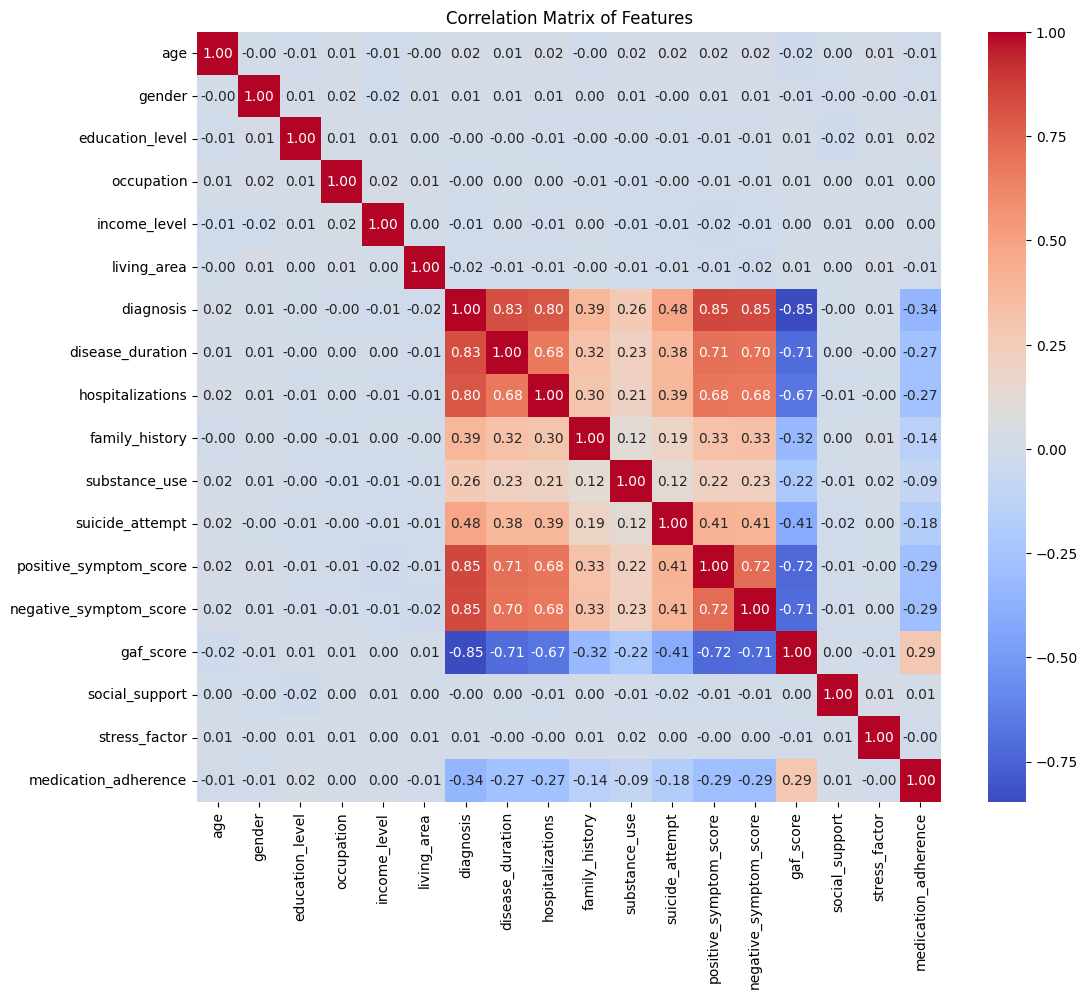

'\nUsing linear models for this may not be good option, since its affected by multicollinearity and redundancy\n\nFeatures dengan high correlation dengan diagnosis, kita beri weight yang lebih besar\n\nRisk factornya gua itung dengan logika simple, feel free to change it if you find a better one\n\nlogikanya: higher correlation -> higher weight for schizophrenia to occur\n'

In [4]:
df_train, df_test = train_test_split(df_cleaned, test_size=0.25, random_state=42, stratify=df_cleaned['diagnosis'])

scaler = MinMaxScaler()
df_train[numerical_cols_to_scale] = scaler.fit_transform(df_train[numerical_cols_to_scale])
df_test[numerical_cols_to_scale] = scaler.transform(df_test[numerical_cols_to_scale])

# Calculate the correlation matrix
correlation_matrix = df_train.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

"""
Using linear models for this may not be good option, since its affected by multicollinearity and redundancy

Features dengan high correlation dengan diagnosis, kita beri weight yang lebih besar

Risk factornya gua itung dengan logika simple, feel free to change it if you find a better one

logikanya: higher correlation -> higher weight for schizophrenia to occur
"""

In [5]:
df_train['risk_factor'] = (df_train['disease_duration'] * 0.5) + \
                          (df_train['hospitalizations'] * 0.5) + \
                          (df_train['positive_symptom_score'] * 0.5) + \
                          (df_train['gaf_score'] * 0.1) + \
                          (df_train['substance_use'] + df_train['family_history'] + \
                           df_train['suicide_attempt'] + df_train['stress_factor'] - \
                           df_train['social_support'] - df_train['medication_adherence'])

df_test['risk_factor'] = (df_test['disease_duration'] * 0.5) + \
                         (df_test['hospitalizations'] * 0.5) + \
                         (df_test['positive_symptom_score'] * 0.5) + \
                         (df_test['gaf_score'] * 0.1) + \
                         (df_test['substance_use'] + df_test['family_history'] + \
                          df_test['suicide_attempt'] + df_test['stress_factor'] - \
                          df_test['social_support'] - df_test['medication_adherence'])


threshold = df_train['risk_factor'].quantile(0.7113)

df_train['relapse'] = (df_train['risk_factor'] > threshold).astype(int)
df_test['relapse'] = (df_test['risk_factor'] > threshold).astype(int)

"""

Living area -> People living in urban areas have higher chance of developing schizo
Income level -> Lower income levels have higher chance of developing schizo
Marital status-> banyak vague factors yang kurang bisa digunakan untuk prediction, lagipula udah ada support system jadi gw drop aja
Education level -> More informed individuals have better protection against early signs of schizophrenia
Occupation ->Retired ppl may have lower cognitive reasoning and panics more easily? asumsi aja sih

"""

'\n\nLiving area -> People living in urban areas have higher chance of developing schizo\nIncome level -> Lower income levels have higher chance of developing schizo\nMarital status-> banyak vague factors yang kurang bisa digunakan untuk prediction, lagipula udah ada support system jadi gw drop aja\nEducation level -> More informed individuals have better protection against early signs of schizophrenia\nOccupation ->Retired ppl may have lower cognitive reasoning and panics more easily? asumsi aja sih\n\n'

In [6]:
cols_to_drop_for_X = ['relapse', 'risk_factor', 'negative_symptom_score', 'positive_symptom_score', 'gaf_score']

# Prepare X_train and y_train
X_train_all_diag = df_train.drop(columns=cols_to_drop_for_X)
y_train_all_diag = df_train['relapse']

X_train_model = X_train_all_diag[X_train_all_diag['diagnosis'] == 1]
y_train_model = y_train_all_diag[X_train_all_diag['diagnosis'] == 1]
X_train_model = X_train_model.drop(columns=['diagnosis'])

X_test_all_diag = df_test.drop(columns=cols_to_drop_for_X)
y_test_all_diag = df_test['relapse']

X_test_model = X_test_all_diag[X_test_all_diag['diagnosis'] == 1]
y_test_model = y_test_all_diag[X_test_all_diag['diagnosis'] == 1]
X_test_model = X_test_model.drop(columns=['diagnosis'])

In [7]:
if not X_train_model.empty:
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_model, y_train_model)
    print("Resampled training set balance:")
    print(pd.Series(y_train_resampled).value_counts())
else:
    print("X_train_model is empty after filtering for diagnosis == 1. SMOTE cannot be applied.")
    X_train_resampled, y_train_resampled = X_train_model, y_train_model

Resampled training set balance:
relapse
0    1306
1    1306
Name: count, dtype: int64


In [8]:
for n in [100, 150, 200, 250, 300, 350, 400]:
    model = RandomForestClassifier(
        n_estimators=n,            # Number of trees
        random_state=42,           # Ensures reproducibility
        max_depth=15,              # Maximum depth of the tree (tune as needed)
        min_samples_split=6,       # Minimum number of samples required to split an internal node
        min_samples_leaf=2,        # Minimum number of samples required to be at a leaf node
        max_features='sqrt',       # Number of features to consider when looking for the best split
        bootstrap=True,            # Whether bootstrap samples are used when building trees
        oob_score=True,            # Use out-of-bag samples to estimate the generalization error
        class_weight='balanced'    # Handle class imbalance if necessary
    )
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_model)
    print(f"N_estimators: {n}")
    print(f"Accuracy: {accuracy_score(y_test_model, y_pred)} F1-Score: {f1_score(y_test_model, y_pred)}")
    print(f"Precision: {precision_score(y_test_model, y_pred)} Recall: {recall_score(y_test_model, y_pred)}")
    print("=====================================================================================================")

N_estimators: 100
Accuracy: 0.961218836565097 F1-Score: 0.9681093394077449
Precision: 0.9860788863109049 Recall: 0.9507829977628636
N_estimators: 150
Accuracy: 0.9584487534626038 F1-Score: 0.9658314350797267
Precision: 0.9837587006960556 Recall: 0.9485458612975392
N_estimators: 200
Accuracy: 0.9570637119113573 F1-Score: 0.9646522234891676
Precision: 0.9837209302325581 Recall: 0.9463087248322147
N_estimators: 250
Accuracy: 0.9556786703601108 F1-Score: 0.9634703196347032
Precision: 0.9836829836829837 Recall: 0.9440715883668904
N_estimators: 300
Accuracy: 0.9584487534626038 F1-Score: 0.9658314350797267
Precision: 0.9837587006960556 Recall: 0.9485458612975392
N_estimators: 350
Accuracy: 0.9556786703601108 F1-Score: 0.9633867276887872
Precision: 0.9859484777517564 Recall: 0.941834451901566
N_estimators: 400
Accuracy: 0.9556786703601108 F1-Score: 0.9633867276887872
Precision: 0.9859484777517564 Recall: 0.941834451901566


In [9]:

if not X_train_resampled.empty and not X_test_model.empty:
    # Align columns - SMOTE might return a NumPy array, so convert back to DataFrame if needed, or ensure X_test_model has same columns as X_train_model
    if not isinstance(X_train_resampled, pd.DataFrame):
        X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train_model.columns)
    X_test_model = X_test_model[X_train_resampled.columns]


    # Best hyperparameters
    model = RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            max_depth=15,
            min_samples_split=6,
            min_samples_leaf=2,
            max_features='sqrt',
            bootstrap=True,
            oob_score=True,
            class_weight='balanced'
        )

    model.fit(X_train_resampled, y_train_resampled)

    if not X_test_model.empty:
        y_pred = model.predict(X_test_model)
        print("=====================================================================================================")
        print(f"N_estimators: 250 (Evaluated on correctly processed test set)")
        print(f"Accuracy: {accuracy_score(y_test_model, y_pred)} F1-Score: {f1_score(y_test_model, y_pred)}")
        print(f"Precision: {precision_score(y_test_model, y_pred)} Recall: {recall_score(y_test_model, y_pred)}")
        print("=====================================================================================================")
    else:
        print("X_test_model is empty. Cannot evaluate.")

else:
    print("Training data is empty after SMOTE or test data is empty. Model training and evaluation skipped.")

N_estimators: 250 (Evaluated on correctly processed test set)
Accuracy: 0.961218836565097 F1-Score: 0.9681093394077449
Precision: 0.9860788863109049 Recall: 0.9507829977628636


In [10]:
import joblib

# Save the model
filename = 'finalized_model.sav'
joblib.dump(model, filename)

['finalized_model.sav']

In [11]:
# Extended work: PCA and Feature analysis
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)

X_train_pca = pca.fit_transform(X_train_resampled.copy())
X_test_pca = pca.transform(X_test_model.copy())

In [12]:
pca.explained_variance_ratio_
# These variance shows that no one feature is a strong indicator, above 0.5 explained variance

array([0.27590683, 0.16910666, 0.09335328, 0.09285308, 0.09067256,
       0.08187559, 0.03699241, 0.03478235, 0.0331636 , 0.02966949,
       0.02654563])

In [13]:
for n in [100, 150, 200, 250, 300, 350, 400]:
    model = RandomForestClassifier(
        n_estimators=n,            # Number of trees
        random_state=42,           # Ensures reproducibility
        max_depth=15,              # Maximum depth of the tree (tune as needed)
        min_samples_split=6,       # Minimum number of samples required to split an internal node
        min_samples_leaf=2,        # Minimum number of samples required to be at a leaf node
        max_features='sqrt',       # Number of features to consider when looking for the best split
        bootstrap=True,            # Whether bootstrap samples are used when building trees
        oob_score=True,            # Use out-of-bag samples to estimate the generalization error
        class_weight='balanced'    # Handle class imbalance if necessary
    )
    model.fit(X_train_pca, y_train_resampled)
    y_pred = model.predict(X_test_pca)
    print(f"N_estimators: {n}")
    print(f"Accuracy: {accuracy_score(y_test_model, y_pred)} F1-Score: {f1_score(y_test_model, y_pred)}")
    print(f"Precision: {precision_score(y_test_model, y_pred)} Recall: {recall_score(y_test_model, y_pred)}")
    print("=====================================================================================================")

N_estimators: 100
Accuracy: 0.9058171745152355 F1-Score: 0.9223744292237442
Precision: 0.9417249417249417 Recall: 0.9038031319910514
N_estimators: 150
Accuracy: 0.9141274238227147 F1-Score: 0.9292237442922374
Precision: 0.9487179487179487 Recall: 0.9105145413870246
N_estimators: 200
Accuracy: 0.9085872576177285 F1-Score: 0.9246575342465754
Precision: 0.9440559440559441 Recall: 0.9060402684563759
N_estimators: 250
Accuracy: 0.9085872576177285 F1-Score: 0.9248291571753986
Precision: 0.9419953596287703 Recall: 0.9082774049217002
N_estimators: 300
Accuracy: 0.909972299168975 F1-Score: 0.926052332195677
Precision: 0.9421296296296297 Recall: 0.9105145413870246
N_estimators: 350
Accuracy: 0.9085872576177285 F1-Score: 0.9246575342465754
Precision: 0.9440559440559441 Recall: 0.9060402684563759
N_estimators: 400
Accuracy: 0.909972299168975 F1-Score: 0.926052332195677
Precision: 0.9421296296296297 Recall: 0.9105145413870246


In [14]:

if not X_train_resampled.empty and not X_test_model.empty:
    # Align columns - SMOTE might return a NumPy array, so convert back to DataFrame if needed, or ensure X_test_model has same columns as X_train_model
    if not isinstance(X_train_resampled, pd.DataFrame):
        X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train_model.columns)
    X_test_model = X_test_model[X_train_resampled.columns]


    # Best hyperparameters
    model = RandomForestClassifier(
            n_estimators=250,
            random_state=42,
            max_depth=15,
            min_samples_split=6,
            min_samples_leaf=2,
            max_features='sqrt',
            bootstrap=True,
            oob_score=True,
            class_weight='balanced'
        )


    model.fit(X_train_pca, y_train_resampled)

    if not X_test_model.empty:
        y_pred = model.predict(X_test_pca)
        print("=====================================================================================================")
        print(f"N_estimators: 250 (Evaluated on correctly processed test set)")
        print(f"Accuracy: {accuracy_score(y_test_model, y_pred)} F1-Score: {f1_score(y_test_model, y_pred)}")
        print(f"Precision: {precision_score(y_test_model, y_pred)} Recall: {recall_score(y_test_model, y_pred)}")
        print("=====================================================================================================")
    else:
        print("X_test_model is empty. Cannot evaluate.")


N_estimators: 250 (Evaluated on correctly processed test set)
Accuracy: 0.9085872576177285 F1-Score: 0.9248291571753986
Precision: 0.9419953596287703 Recall: 0.9082774049217002


In [15]:
# Using PCA, we found that performance dropped for the same hyperparameters, this aligns well and shows our model does not overfit.

In [16]:
importances = model.feature_importances_
feature_names = X_train_model.columns[:11]  # if using pandas DataFrame
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

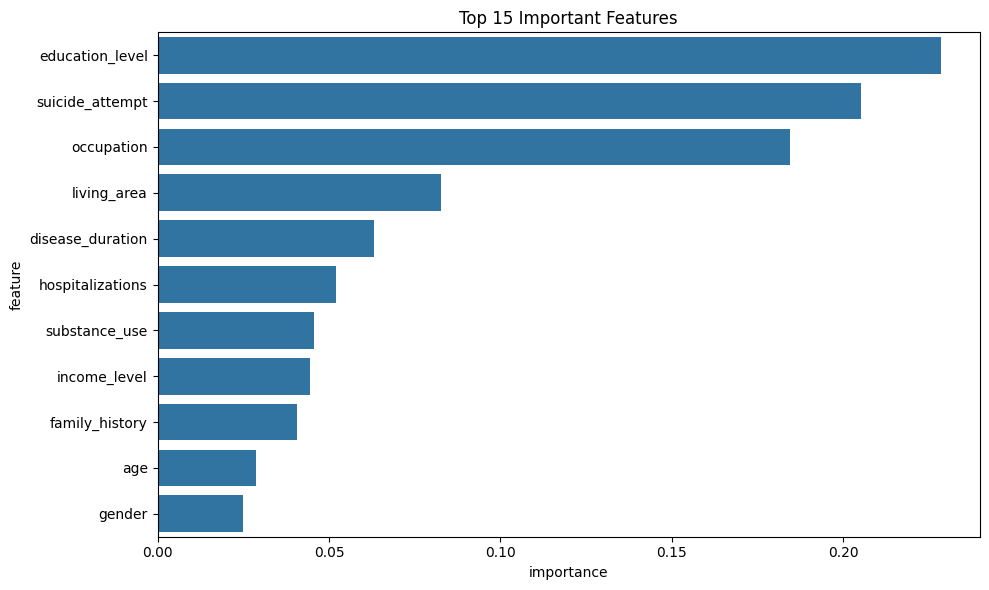

In [17]:
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(11))
plt.title("Top 15 Important Features")
plt.tight_layout()
plt.show()